In [1]:
# If additional packages need to be used, uncomment the last two lines of this cell and replace <package list> with 
# a list of additional packages.
# This will ensure the notebook has all the dependencies satisfied and works everywhere.

#import sys
#!{sys.executable} -m pip install <package list>

### Libraries

#### Here, we will import all the necessary libraries required to do the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

In [475]:
import pandas as pd
import datetime as dt
from pandas.plotting import scatter_matrix 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Data Description

Feature | Description
:---|:---
app_id |The unique application id.
category | The category under which app is categorized on the store.
reviews| The number of reviews received on the store.
size| Size of the app available for download (in KB/MB)
installs| The number of people who had installed this app atleast once.
price| The price of the app (in US $)
suitable_for| Rating given to app based on the usage and content.
last_update| When was the app updated last time by the developers.
latest_ver| The latest version of the app available for download.
popularity| User popularity (High/Low)

# Data Wrangling & Visualization 




In [476]:
train = pd.read_csv("train.csv")
train.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511k,50+,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5.2M,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70M,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96M,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4.5M,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High


In [477]:
#Description
train.describe()

,app_id,reviews
count,1975.000,1975.000
mean,490685.787,198816.163
std,288098.937,1494090.662
min,1160.000,1.000
25%,239249.500,33.000
50%,481867.000,516.000
75%,737373.500,19122.000
max,999218.000,44891723.000


In [478]:
# exploring data types of the feature columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 10 columns):
app_id          1975 non-null int64
category        1975 non-null object
reviews         1975 non-null int64
size            1975 non-null object
installs        1975 non-null object
price           1975 non-null object
suitable_for    1975 non-null object
last_update     1975 non-null object
latest_ver      1971 non-null object
popularity      1975 non-null object
dtypes: int64(2), object(8)
memory usage: 154.4+ KB


In [479]:
# drop the rows with null latest_ver values
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1974
Data columns (total 10 columns):
app_id          1971 non-null int64
category        1971 non-null object
reviews         1971 non-null int64
size            1971 non-null object
installs        1971 non-null object
price           1971 non-null object
suitable_for    1971 non-null object
last_update     1971 non-null object
latest_ver      1971 non-null object
popularity      1971 non-null object
dtypes: int64(2), object(8)
memory usage: 169.4+ KB


#### From the above code cell, it looks like some columns that ought to be numeric are present as object or string data types. We need to convert these column data types to numeric so that we can use them as useful features in a machine learning model.

In [480]:
# 1. first create a new copy of the dataframe
train_df = train.copy()

# convert the size feature into proper numers
notation_dict = {'M': 1_000_000, 'k':1000}

# create the conversion function
def convert_to_proper_no(value):
    value = str(value)
    notation = value[-1]
    numeric = float(value[:-1]) * notation_dict[notation]
    return numeric

train_df['size'] = train_df['size'].apply(convert_to_proper_no)

# now take a look at the dataframe to see if values have changed successfully
train_df.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511000.000,50+,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5200000.000,"5,000,000+",0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70000000.000,"1,000+",$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96000000.000,"10,000,000+",0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4500000.000,"1,000+",0,Mature 17+,"July 6, 2018",8.2,High


In [481]:
# 2. Remove the + signs from the installs column
# Expectation is more is number of installs, higher is the app popularity

train_df['installs'] = train_df['installs'].apply(lambda v: int(v[:-1].replace(",", "")))

# now take a look at the dataframe to see if values have changed successfully
train_df.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511000.000,50,0,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5200000.000,5000000,0,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70000000.000,1000,$2.99,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96000000.000,10000000,0,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4500000.000,1000,0,Mature 17+,"July 6, 2018",8.2,High


In [482]:
# 3. Remove the $ signs from price and convert to float
# Expectation is somewhat subjective here. While free apps can be popular, there are often paid apps that are popular as well.

train_df['price'] = train_df['price'].apply(lambda v: float(v.replace("$", "")))

# now take a look at the dataframe to see if values have changed successfully
train_df.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511000.000,50,0.000,Everyone,"December 31, 2016",1.4,High
1,226147,GAME,568391,5200000.000,5000000,0.000,Teen,"July 1, 2014",4.3.1,High
2,107000,FAMILY,144,70000000.000,1000,2.990,Teen,"January 26, 2018",1.0.0,High
3,217582,FAMILY,1499466,96000000.000,10000000,0.000,Teen,"July 24, 2018",1.25.0,High
4,370113,DATING,84,4500000.000,1000,0.000,Mature 17+,"July 6, 2018",8.2,High


In [483]:
# 4. Convert the last update column to time since epoch
# Expectation is , the latest an app has been updated (larger time since epoch), the more popular is the app

# first convert the last_update column to datetime
train_df['last_update'] = pd.to_datetime(train_df['last_update'])

# now convert the column to time since epoch i.e (1970/01/01)
train_df['last_update'] = (train_df['last_update'] - dt.datetime(1970,1,1)).dt.total_seconds()

# now take a look at the dataframe to see if values have changed successfully
train_df.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver,popularity
0,330090,PERSONALIZATION,4,511000.000,50,0.000,Everyone,1483142400.000,1.4,High
1,226147,GAME,568391,5200000.000,5000000,0.000,Teen,1404172800.000,4.3.1,High
2,107000,FAMILY,144,70000000.000,1000,2.990,Teen,1516924800.000,1.0.0,High
3,217582,FAMILY,1499466,96000000.000,10000000,0.000,Teen,1532390400.000,1.25.0,High
4,370113,DATING,84,4500000.000,1000,0.000,Mature 17+,1530835200.000,8.2,High


In [1]:
# 5. Convert the latest_ver column to a float with only major and minor revisions of software. Ignore patch number
# Expectation is , higher is the version number, the higher should be the probability

# define the conversion function
def convert_to_numeric_version(value):
    dot_counts = value.count(".")
    if dot_counts > 1:
        return float(value.rsplit(".", dot_counts-1)[0])
    else:
        return float(value)
    
train_df['latest_ver'] = train_df['latest_ver'].apply(convert_to_numeric_version)

# now take a look at the dataframe to see if values have changed successfully
train_df.head()

NameError: name 'train_df' is not defined

#### Let us look at the unimodal distributions of the numerical columns. It can be seen that most of the columns exhibit highly skewed features which often negatively impact machine learning model performance.

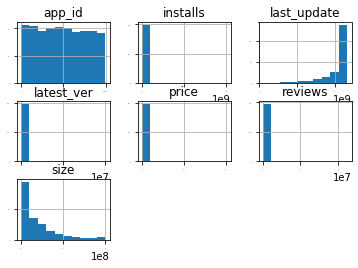

In [485]:
# observe numeric column distributions
train_df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

In [486]:
# 6. let us use a log transformation to transform the skewed features to as close as normal distributions
train_df_transformed = train_df.copy()
cols_to_transform = ['reviews', 'size', 'installs', 'price', 'last_update', 'latest_ver']

for col in cols_to_transform:
    train_df_transformed[col] = train_df_transformed[col].apply(lambda x: np.log(x + 1))

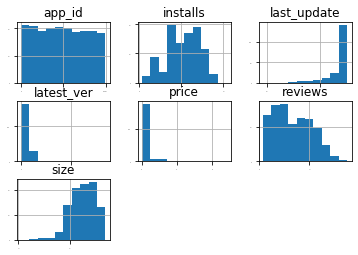

In [487]:
# now the distributions on the highly skewed features look much more closer to normal distributions
train_df_transformed.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1);

In [488]:
# lets lok at the data types of the dataframe we have so far
train_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1974
Data columns (total 10 columns):
app_id          1971 non-null int64
category        1971 non-null object
reviews         1971 non-null float64
size            1971 non-null float64
installs        1971 non-null float64
price           1971 non-null float64
suitable_for    1971 non-null object
last_update     1971 non-null float64
latest_ver      1971 non-null float64
popularity      1971 non-null object
dtypes: float64(6), int64(1), object(3)
memory usage: 169.4+ KB


In [489]:
# let us drop the app id column since it doesnt seem to be important in predicting app popularity.
# Lets also divide the dataframe into X and Y i.e features and targets

# we will end up with 8 features
X = train_df_transformed.drop(['app_id', 'popularity'], axis=1)
Y = train_df_transformed['popularity']

In [490]:
# lets look at X once more
X.head()

,category,reviews,size,installs,price,suitable_for,last_update,latest_ver
0,PERSONALIZATION,1.609,13.144,3.932,0.000,Everyone,21.117,0.875
1,GAME,13.251,15.464,15.425,0.000,Teen,21.063,1.668
2,FAMILY,4.977,18.064,6.909,1.384,Teen,21.140,0.693
3,FAMILY,14.221,18.380,16.118,0.000,Teen,21.150,0.811
4,DATING,4.443,15.320,6.909,0.000,Mature 17+,21.149,2.219


In [491]:
# we will need to do one hot encoding on categorical columns and feature scaling on numeric columns before we can 
# fit the data to a model

# first extract the numeric and categorical columns
numeric_cols = [col for col in X.columns if X[col].dtype != 'O']
categorical_cols = [col for col in X.columns if X[col].dtype == 'O']

# create a transformer pipeline to do proper transformation to the columns
ohe = OneHotEncoder() # one hot encodes categorical columns
scaler = StandardScaler() # standardizes numerical columns for more uniform feature scaling across columns

ct = make_column_transformer(
    (ohe, categorical_cols),
    (scaler, numeric_cols),
    remainder='passthrough'
)

# do the transformation of columns
X = ct.fit_transform(X)

In [492]:
# now convert the target vector "popularity" into encode variable needed for input into ML algo
le = LabelEncoder()
Y = le.fit_transform(Y)
Y

array([0, 0, 0, ..., 0, 0, 0])

In [493]:
Y.shape

(1971,)

In [494]:
X.shape

(1971, 44)

In [495]:
pd.DataFrame(data=X.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-1.345,-2.516,-1.676,-0.289,-0.807,-0.352
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.719,-0.622,1.307,-0.289,-3.213,0.380
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-0.459,1.501,-0.904,2.410,0.184,-0.521
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.975,1.759,1.487,-0.289,0.630,-0.412
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,-0.599,-0.740,-0.904,-0.289,0.585,0.889


# Visualization, Modeling, Machine Learning

Build a model that can predict whether an app will become be trending or not and determine how different features influence the outcome. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of Accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [496]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver
0,144236,TOOLS,262076,1.2M,"10,000,000+",0,Everyone,"January 4, 2018",1.0.2
1,881323,PHOTOGRAPHY,12204,6.8M,"1,000,000+",0,Everyone,"March 14, 2017",1.5.2.21
2,765524,TOOLS,632,8.2M,"500,000+",0,Everyone,"May 23, 2017",1.0
3,390533,BUSINESS,29,16M,500+,0,Everyone,"July 5, 2018",2.2.1335
4,817383,ART_AND_DESIGN,192,6.0M,"10,000+",0,Everyone,"April 25, 2018",1.5


In [3]:
# split the dataset into train and validation sets. here we follow a 70-30% split
validation_size = 0.30 
seed = 42 
# now do the split
X_train, X_validation, Y_train, Y_validation = train_test_split(X.toarray(), Y,test_size=validation_size, random_state=seed)

In [498]:
# Evaluate an array on algorithms to decide on baseline performance
num_folds = 10 
seed = 42
scoring = 'accuracy'

In [499]:
# select a series of candidate classifier algorithms with DEFAULT parameters. The target variable is highly
# imbalanced so we will assign adaptive weights to the targets via the class_weight parameter

models = [] 
models.append((' LR' , LogisticRegression(solver='liblinear', class_weight='balanced'))) 
models.append((' KNN' , KNeighborsClassifier())) 
models.append((' DT' , DecisionTreeClassifier(class_weight='balanced'))) 
models.append((' NB' , GaussianNB()))
models.append((' SVM' , SVC(gamma='auto', class_weight='balanced')))

#### The algorithms all use default tuning parameters. Let’s compare the algorithms. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [500]:
results = [] 
names = [] 

for name, model in models: 
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results) 
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 LR: 0.725188 (0.032292)
 KNN: 0.728102 (0.028918)
 DT: 0.683090 (0.040975)
 NB: 0.323416 (0.023977)
 SVM: 0.682387 (0.032776)


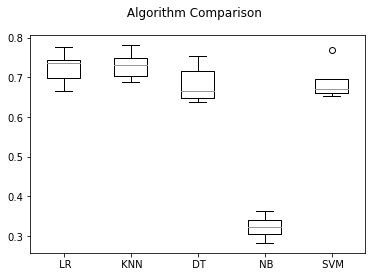

In [501]:
# Compare Algorithms 
fig = plt.figure() 
fig.suptitle(' Algorithm Comparison' ) 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names);

#### The result shows, Logistic Regression Classifier (LR) to perform the best (72.5% accuracy) on a 10 fold cross validated dataset with the least amount of variance in accuracy values across the 10 folds. Below, we do a grid search on the hyperparameters of SVC to tune the model further.

In [502]:
c_values = np.logspace(-4, 4, 20)
penalty = ['l1', 'l2']
solver =  ['liblinear']


param_grid = dict(C=c_values, penalty=penalty, solver=solver) 
model = LogisticRegression(class_weight='balanced') 

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold) 
grid_result = grid.fit(X_train, Y_train)
best_model = grid.best_estimator_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.732415 using {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}


#### The best model from grid search has improved accuracy of 73.2%. Below, we will analyse feature importance.

In [503]:
# lets first look at the dataset the model takes as an input
one_hot_cats = list(ct.named_transformers_['onehotencoder'].get_feature_names())
all_features = one_hot_cats + numeric_cols

X_df = pd.DataFrame(data=X.toarray(), columns=all_features)
X_df.head()

,x0_ART_AND_DESIGN,x0_AUTO_AND_VEHICLES,x0_BEAUTY,x0_BOOKS_AND_REFERENCE,x0_BUSINESS,x0_COMICS,x0_COMMUNICATION,x0_DATING,x0_EDUCATION,x0_ENTERTAINMENT,x0_EVENTS,x0_FAMILY,x0_FINANCE,x0_FOOD_AND_DRINK,x0_GAME,x0_HEALTH_AND_FITNESS,x0_HOUSE_AND_HOME,x0_LIBRARIES_AND_DEMO,x0_LIFESTYLE,x0_MAPS_AND_NAVIGATION,x0_MEDICAL,x0_NEWS_AND_MAGAZINES,x0_PARENTING,x0_PERSONALIZATION,x0_PHOTOGRAPHY,x0_PRODUCTIVITY,x0_SHOPPING,x0_SOCIAL,x0_SPORTS,x0_TOOLS,x0_TRAVEL_AND_LOCAL,x0_VIDEO_PLAYERS,x0_WEATHER,x1_Adults only 18+,x1_Everyone,x1_Everyone 10+,x1_Mature 17+,x1_Teen,reviews,size,installs,price,last_update,latest_ver
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-1.345,-2.516,-1.676,-0.289,-0.807,-0.352
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.719,-0.622,1.307,-0.289,-3.213,0.380
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-0.459,1.501,-0.904,2.410,0.184,-0.521
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.975,1.759,1.487,-0.289,0.630,-0.412
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,-0.599,-0.740,-0.904,-0.289,0.585,0.889


In [504]:
# Feature Importance
# get importance
importance = best_model.coef_[0]
    
# plot feature importance
xx = [x for x in range(len(importance))]

In [2]:
sns.set(font_scale=1)
f, ax = plt.subplots(1,1, figsize=(20, 10))
chart = sns.barplot(xx, importance, ax=ax)
chart.set_xticklabels(labels = all_features, rotation=90);

#### The chart shows the feature importance of all the features. The higher the bar, the more is the importance. It looks like the number of installations and the number of reviews have the highest effect on popularity score.

- **Submit the predictions on the test dataset using your optimized model**

    For each record in the test set (`test.csv`), predict the `popularity` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **app_id**
   - **popularity**

In [506]:
# do all the data preprocessing on the test data set
test_df = test_data.copy()
test_df.dropna(inplace=True)
test_df.head()

,app_id,category,reviews,size,installs,price,suitable_for,last_update,latest_ver
0,144236,TOOLS,262076,1.2M,"10,000,000+",0,Everyone,"January 4, 2018",1.0.2
1,881323,PHOTOGRAPHY,12204,6.8M,"1,000,000+",0,Everyone,"March 14, 2017",1.5.2.21
2,765524,TOOLS,632,8.2M,"500,000+",0,Everyone,"May 23, 2017",1.0
3,390533,BUSINESS,29,16M,500+,0,Everyone,"July 5, 2018",2.2.1335
4,817383,ART_AND_DESIGN,192,6.0M,"10,000+",0,Everyone,"April 25, 2018",1.5


In [507]:
test_df['size'] = test_df['size'].apply(convert_to_proper_no)
test_df['installs'] = test_df['installs'].apply(lambda v: int(v[:-1].replace(",", "")))
test_df['price'] = test_df['price'].apply(lambda v: float(v.replace("$", "")))
test_df['last_update'] = pd.to_datetime(test_df['last_update'])
test_df['last_update'] = (test_df['last_update'] - dt.datetime(1970,1,1)).dt.total_seconds()
test_df['latest_ver'] = test_df['latest_ver'].apply(convert_to_numeric_version)

In [508]:
cols_to_transform = ['reviews', 'size', 'installs', 'price', 'last_update', 'latest_ver']

for col in cols_to_transform:
    test_df[col] = test_df[col].apply(lambda x: np.log(x + 1))

In [509]:
X_test = test_df.drop(['app_id'], axis=1)
X_test = ct.transform(X_test)

In [510]:
predictions = best_model.predict(X_test)

In [511]:
submission_df = pd.DataFrame(data={'app_id': test_df['app_id'],
                                  'popularity': predictions})
submission_df['popularity'] = submission_df['popularity'].map({0: 'High', 1: 'Low'})
submission_df.head()

,app_id,popularity
0,144236,High
1,881323,Low
2,765524,Low
3,390533,High
4,817383,High


In [512]:
#Submission
submission_df.to_csv('submissions.csv',index=False)